# Analyze Metrics and Conduct Inference.ipynb

In [49]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from Analysis_Functions import *


In [50]:
# Load Combined_Data.xlsx
combined_data = pd.read_excel('Combined_Data.xlsx')

# GSM8k data - limit to task = "gsm8k"
gsm8k_data = combined_data[combined_data['task'] == 'gsm8k']

# Creative writing data - limit to task = "cw"
cw_data = combined_data[combined_data['task'] == 'cw']


## Length

Run generic function for length of entire interaction, length of all prompts, financial cost

Baseline comparison ratios, change in accuracy/quality plots

In [51]:
means_table(combined_data, 'conversation_length')
means_table(combined_data, 'input_length')
means_table(combined_data, 'conversation_cost')


  model   task  ape_zero_shot_cot  direct_prompting  least_to_most  \
0  gpt4     cw             470.72            337.33        1091.41   
2   td3     cw             274.04            200.41        1025.02   
1  gpt4  gsm8k             243.93            146.69         332.36   
3   td3  gsm8k             181.76             87.06         272.27   

   manual_cot  manual_few_shot  self_refine  tree_of_thought  zero_shot_cot  
0      968.75           751.04       520.06          1325.17         459.98  
2      960.51           695.41       382.19           916.81         256.53  
1      850.04           579.69       344.86           764.72         223.88  
3      722.70           533.94       125.99           248.80         166.02  
  model   task  ape_zero_shot_cot  direct_prompting  least_to_most  \
0  gpt4     cw              84.89             65.89         754.89   
2   td3     cw              73.49             52.49         736.49   
1  gpt4  gsm8k              93.50             72.

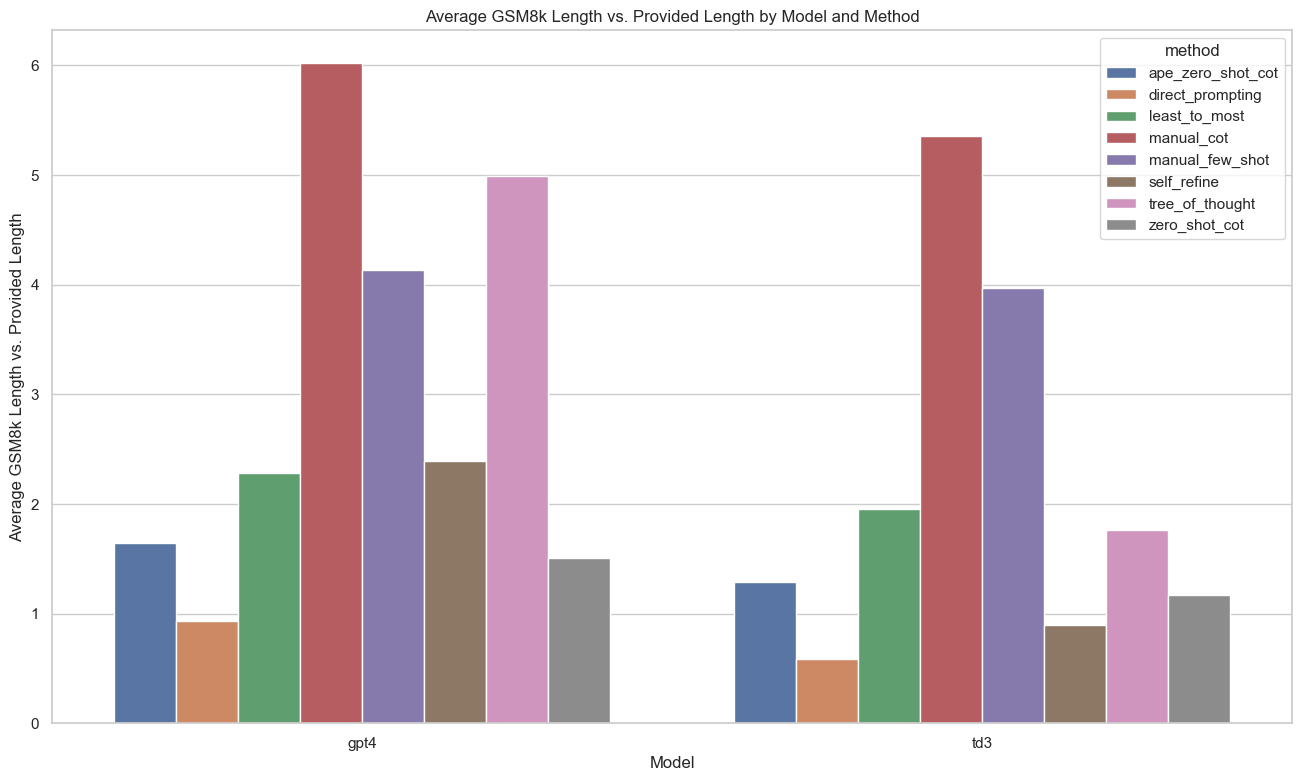

In [52]:
# Plot gsm8k_length_vs_provided in a bar chart
# Limit to gsm8k data
# Get means by model, method
gsm8k_length_vs_provided_means = gsm8k_data[['model', 'method', 'gsm8k_length_vs_provided']].groupby(['model', 'method']).agg(['mean'])['gsm8k_length_vs_provided'].reset_index()

# Bar chart by model, method
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 9))
sns.barplot(x='model', y='mean', hue='method', data=gsm8k_length_vs_provided_means)
plt.xlabel('Model')
plt.ylabel('Average GSM8k Length vs. Provided Length')
plt.title('Average GSM8k Length vs. Provided Length by Model and Method')
plt.savefig('../Output/gsm8k_length_vs_provided_means.png')
plt.show()


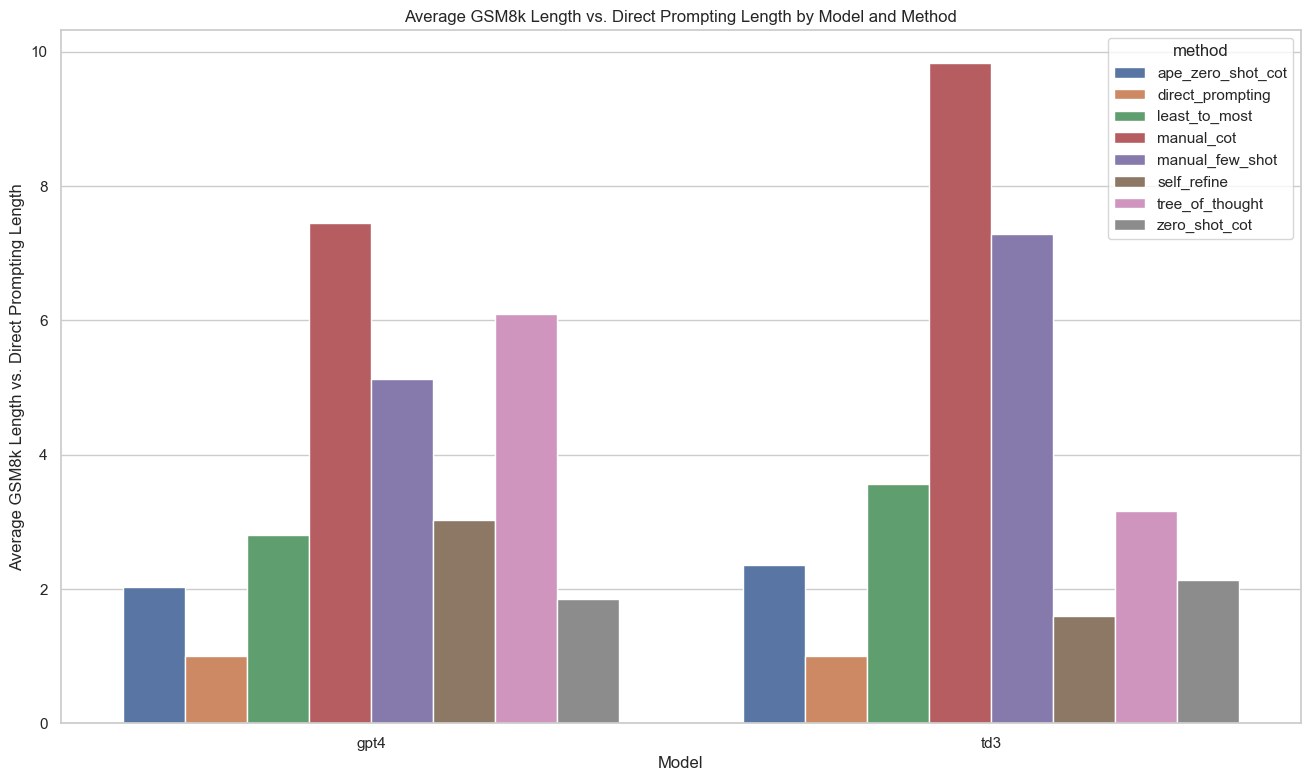

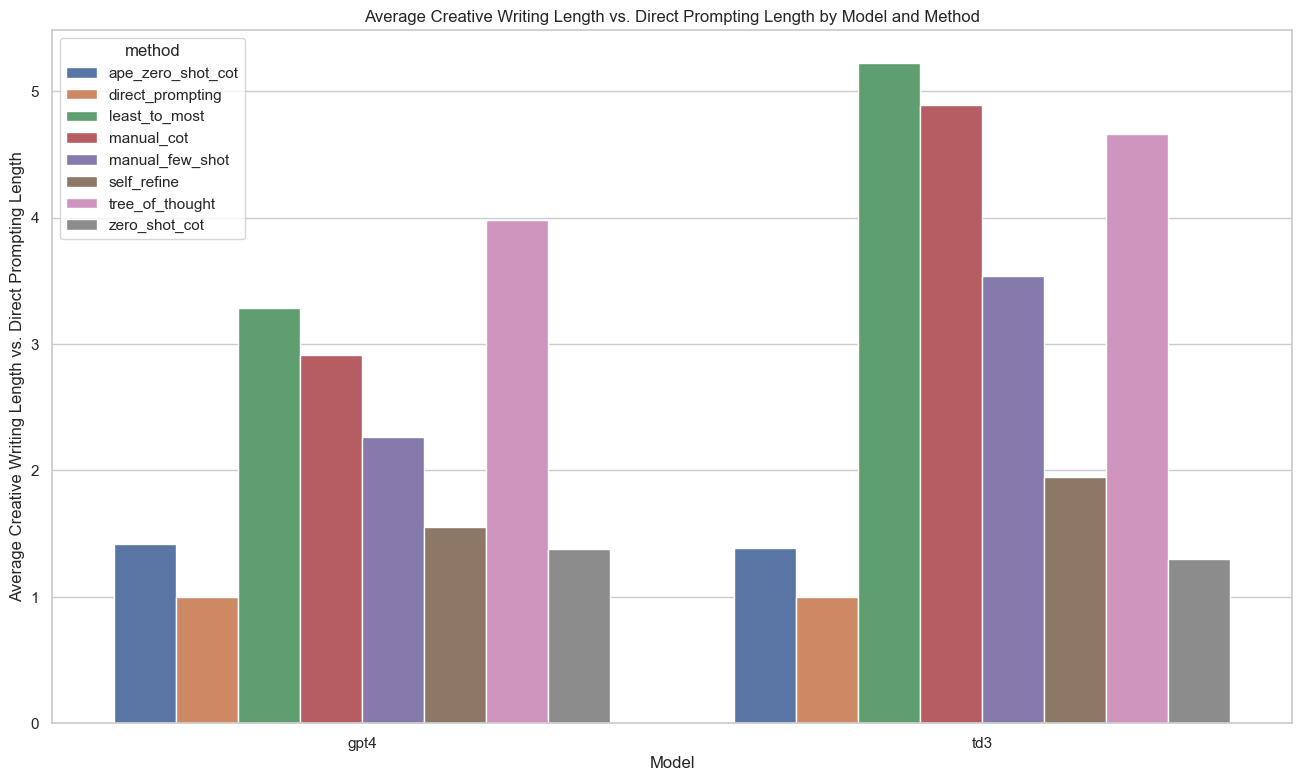

In [53]:
# Plot length_vs_direct_prompting in a bar chart
# Get means by model, method, task
length_vs_direct_prompting_means = combined_data[['model', 'method', 'task', 'length_vs_direct_prompting']].groupby(['model', 'method', 'task']).agg(['mean'])['length_vs_direct_prompting'].reset_index()

# Bar chart by model, method, task

# GSM8k plot
plt.figure(figsize=(16, 9))
sns.barplot(x='model', y='mean', hue='method', data=length_vs_direct_prompting_means[length_vs_direct_prompting_means['task'] == 'gsm8k'])
plt.xlabel('Model')
plt.ylabel('Average GSM8k Length vs. Direct Prompting Length')
plt.title('Average GSM8k Length vs. Direct Prompting Length by Model and Method')
plt.savefig('../Output/gsm8k_length_vs_direct_prompting_means.png')
plt.show()

# Creative writing plot
plt.figure(figsize=(16, 9))
sns.barplot(x='model', y='mean', hue='method', data=length_vs_direct_prompting_means[length_vs_direct_prompting_means['task'] == 'cw'])
plt.xlabel('Model')
plt.ylabel('Average Creative Writing Length vs. Direct Prompting Length')
plt.title('Average Creative Writing Length vs. Direct Prompting Length by Model and Method')
plt.savefig('../Output/cw_length_vs_direct_prompting_means.png')
plt.show()


In [54]:
# Compute change in accuracy/quality per change in length (versus direct prompting)
direct_prompting_comparison = pd.read_excel('direct_prompting_comparison.xlsx')

# In the direct_prompting_comparison table, get averages of conversation_length, dp_conversation_length, accuracy_quality, dp_accuracy_quality by model, method, task
averages_for_changes = direct_prompting_comparison[['model', 'method', 'task', 'conversation_length', 'dp_conversation_length', 'accuracy_quality', 'dp_accuracy_quality']].groupby(['model', 'method', 'task']).agg(['mean']).reset_index()

# Compute change in accuracy_quality per change in conversation_length
# accuracy_quality - dp_accuracy_quality
# divided by
# conversation_length - dp_conversation_length
averages_for_changes['change_in_accuracy_quality_per_change_in_conversation_length'] = (averages_for_changes['accuracy_quality']['mean'] - averages_for_changes['dp_accuracy_quality']['mean']) / (averages_for_changes['conversation_length']['mean'] - averages_for_changes['dp_conversation_length']['mean'])


In [55]:
# Look just at change in accuracy quality
just_change_acc_qual = averages_for_changes
just_change_acc_qual['change_in_accuracy_quality'] = (just_change_acc_qual['accuracy_quality']['mean'] - just_change_acc_qual['dp_accuracy_quality']['mean'])
# Sort by task, method, model
#just_change_acc_qual = just_change_acc_qual.sort_values(by=['task', 'method', 'model']).reset_index().drop(columns=['index'])

just_change_acc_qual = just_change_acc_qual[['model', 'method', 'task', 'change_in_accuracy_quality']]
# Unstack model column
just_change_acc_qual = just_change_acc_qual.set_index(['task', 'method', 'model']).unstack()

# Column that is gpt4 minus td3
#just_change_acc_qual['gpt4_minus_td3'] = just_change_acc_qual['gpt4'] - just_change_acc_qual['td3']

print(just_change_acc_qual)


                        change_in_accuracy_quality      
                                                        
model                                         gpt4   td3
task  method                                            
cw    ape_zero_shot_cot                      -0.25 -0.56
      least_to_most                          -0.17 -0.01
      manual_cot                              0.62 -0.32
      manual_few_shot                         0.40  0.51
      self_refine                             0.33 -0.26
      tree_of_thought                        -0.95 -1.09
      zero_shot_cot                           0.58 -0.60
gsm8k ape_zero_shot_cot                       0.20  0.26
      least_to_most                           0.22  0.44
      manual_cot                              0.20  0.37
      manual_few_shot                        -0.24 -0.05
      self_refine                             0.16 -0.03
      tree_of_thought                        -0.33  0.00
      zero_shot_cot            

In [56]:
print(averages_for_changes)


   model             method   task conversation_length dp_conversation_length  \
                                                  mean                   mean   
0   gpt4  ape_zero_shot_cot     cw              470.72                 337.33   
1   gpt4  ape_zero_shot_cot  gsm8k              243.93                 146.69   
2   gpt4      least_to_most     cw             1091.41                 337.33   
3   gpt4      least_to_most  gsm8k              332.36                 146.69   
4   gpt4         manual_cot     cw              968.75                 337.33   
5   gpt4         manual_cot  gsm8k              850.04                 146.69   
6   gpt4    manual_few_shot     cw              751.04                 337.33   
7   gpt4    manual_few_shot  gsm8k              579.69                 146.69   
8   gpt4        self_refine     cw              520.06                 337.33   
9   gpt4        self_refine  gsm8k              344.86                 146.69   
10  gpt4    tree_of_thought 

In [57]:
# Recode 'model' as 'Model' - change gpt4 to "GPT-4" and td3 to "Text-Davinci-003"
averages_for_changes['Model'] = averages_for_changes['model'].replace({'gpt4': 'GPT-4', 'td3': 'Text-Davinci-003'})
# Recode 'method' as 'Method' - change ape_zero_shot_cot to "APE Zero-Shot COT", zero_shot_cot to "Zero-Shot COT", least_to_most to "Least-to-Most", manual_cot to "Manual COT", manual_few_shot to "Manual Few-Shot", self_refine to "Self-Refine", tree_of_thought to "Tree-of-Thought"
averages_for_changes['Method'] = averages_for_changes['method'].replace({'ape_zero_shot_cot': 'APE Zero-Shot COT', 'zero_shot_cot': 'Zero-Shot COT', 'least_to_most': 'Least-to-Most', 'manual_cot': 'Manual COT', 'manual_few_shot': 'Manual Few-Shot', 'self_refine': 'Self-Refine', 'tree_of_thought': 'Tree-of-Thought'})


In [58]:
# Create transformed version for gsm8k - multiply change in accuracy_quality per change in conversation_length by 100 to get percentage points improvement per token
averages_for_changes_gsm8k = averages_for_changes[averages_for_changes['task'] == 'gsm8k']
averages_for_changes_gsm8k['Percentage Points Accuracy Improvement Per Additional Token'] = averages_for_changes_gsm8k['change_in_accuracy_quality_per_change_in_conversation_length'] * 100



C:\Users\ijyli\AppData\Local\Temp\ipykernel_21568\1737752169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  averages_for_changes_gsm8k['Percentage Points Accuracy Improvement Per Additional Token'] = averages_for_changes_gsm8k['change_in_accuracy_quality_per_change_in_conversation_length'] * 100


In [59]:
# Create transformed version for cw - multiply change in accuracy_quality per change in conversation length by 1000 to get cw score improvement per 1000 tokens
averages_for_changes_cw = averages_for_changes[averages_for_changes['task'] == 'cw']
averages_for_changes_cw['Coherence Improvement (-10 to 10) Per Additional 1,000 Tokens'] = averages_for_changes_cw['change_in_accuracy_quality_per_change_in_conversation_length'] * 1000



C:\Users\ijyli\AppData\Local\Temp\ipykernel_21568\3580115725.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  averages_for_changes_cw['Coherence Improvement (-10 to 10) Per Additional 1,000 Tokens'] = averages_for_changes_cw['change_in_accuracy_quality_per_change_in_conversation_length'] * 1000


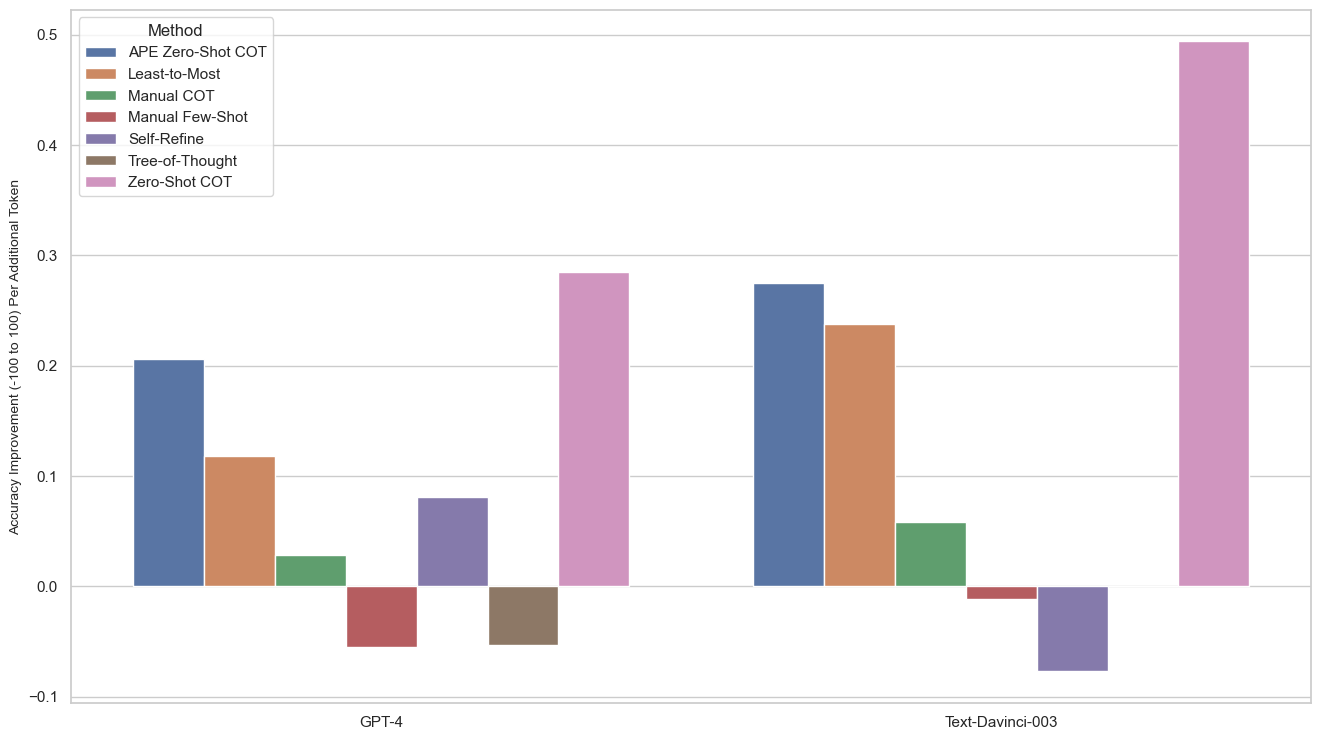

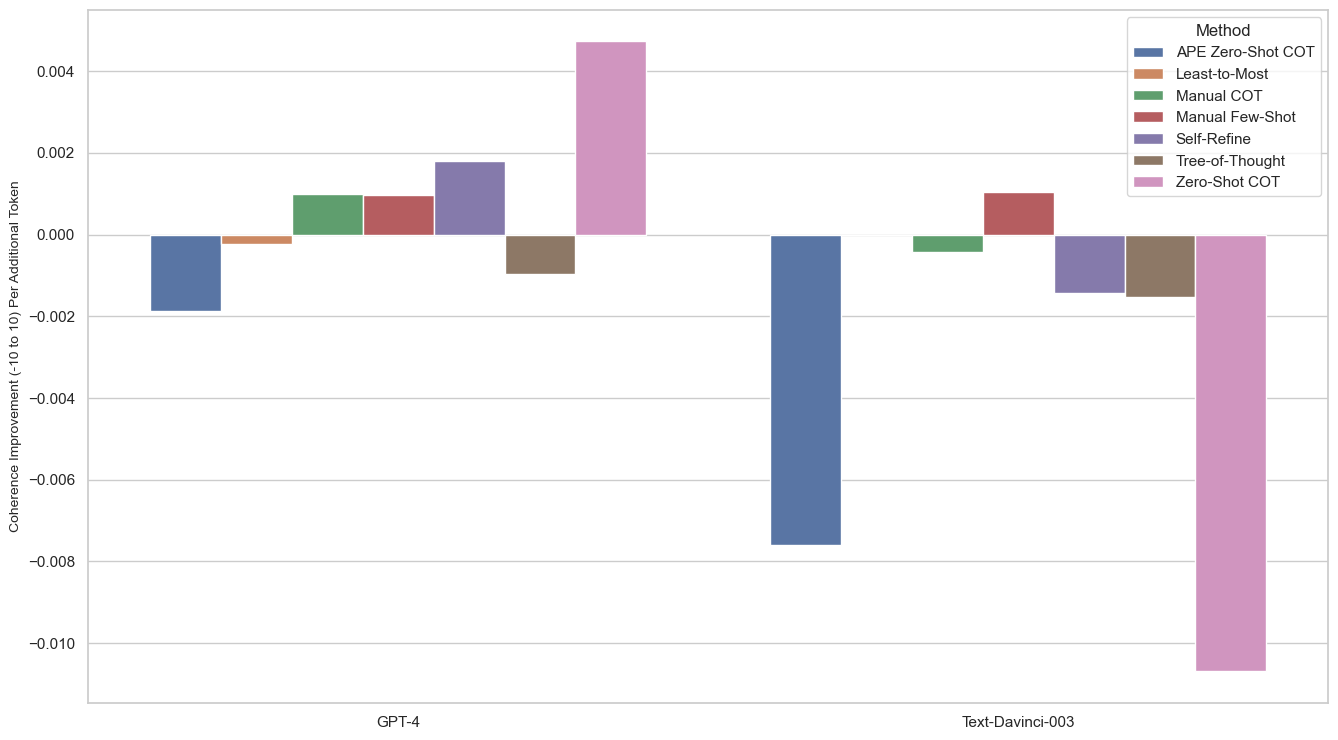

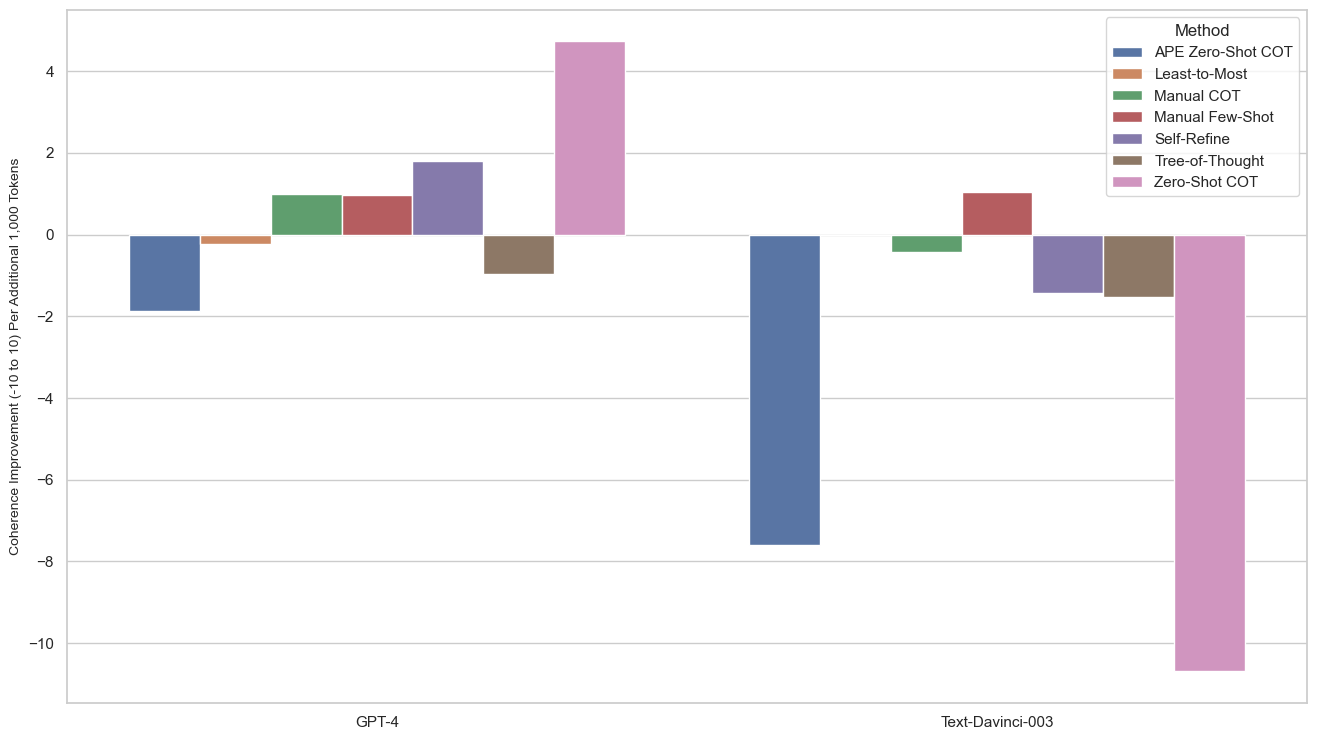

In [60]:
# Plot change in accuracy_quality per change in conversation_length
# Bar chart by model, method, task
# GSM8k plot
plt.figure(figsize=(16, 9))
sns.barplot(x='Model', y='Percentage Points Accuracy Improvement Per Additional Token', hue='Method', data=averages_for_changes_gsm8k)
#plt.xlabel('Model')
#plt.xlabel('')
#plt.ylabel('Change in GSM8K Accuracy per Change in Conversation Length')
# No x axis title
plt.gca().set_xlabel('')
# Reduce y axis title font size
plt.gca().set_ylabel('Accuracy Improvement (-100 to 100) Per Additional Token', fontsize=10)
#plt.title('Change in GSM8K Accuracy per Change in Conversation Length by Model and Method')
plt.savefig('../Output/gsm8k_change_in_accuracy_quality_per_change_in_conversation_length.png')
plt.show()

# Creative writing plot
plt.figure(figsize=(16, 9))
sns.barplot(x='Model', y='change_in_accuracy_quality_per_change_in_conversation_length', hue='Method', data=averages_for_changes_cw)
#plt.xlabel('')
# plt.ylabel('Change in Creative Writing Coherence per Change in Conversation Length')
#plt.title('Change in Creative Writing Coherence per Change in Conversation Length by Model and Method')
# No x axis title
plt.gca().set_xlabel('')
plt.gca().set_ylabel('Coherence Improvement (-10 to 10) Per Additional Token', fontsize=10)
plt.savefig('../Output/cw_change_in_accuracy_quality_per_change_in_conversation_length.png')
plt.show()

# Creative writing plot
plt.figure(figsize=(16, 9))
sns.barplot(x='Model', y='Coherence Improvement (-10 to 10) Per Additional 1,000 Tokens', hue='Method', data=averages_for_changes_cw)
# plt.xlabel('Model')
#plt.xlabel('')
# plt.ylabel('Change in Creative Writing Coherence per Change in Conversation Length')
#plt.title('Change in Creative Writing Coherence per Change in Conversation Length by Model and Method')
# No x axis title
plt.gca().set_xlabel('')
plt.gca().set_ylabel('Coherence Improvement (-10 to 10) Per Additional 1,000 Tokens', fontsize=10)
plt.savefig('../Output/cw_change_in_accuracy_quality_per_change_in_conversation_length_transformed.png')
plt.show()


### Load in method data (hand_labeled_data)

In [61]:
# Release date

# Load Excel file "..\Selection of Prompt Engineering Methods\Hand-Labeled Method and Implementation Considerations.xlsx"
hand_labeled_data = pd.read_excel('..\Selection of Prompt Engineering Methods\Hand-Labeled Method and Implementation Considerations.xlsx')

# Keep columns ss_publication_date, "Prompt Engineering Method"
hand_labeled_data = hand_labeled_data[['ss_publication_date', 'Prompt Engineering Method']]

# Mapping names from this data to technqiue names
# "Few-Shot Learing" -> "manual_few_shot"
# "Chain-of-Thought Prompting" -> "manual_cot"
# "Zero-Shot Chain-of_Thought" -> "zero_shot_cot"
# "Automatic Prompt Engineer" -> "ape_zero_shot_cot"
# "Self-Refine" -> "self_refine"
# "Least-to-Most Prompting" -> "least_to_most"
# "Tree-of-Thought" -> "tree_of_thought"
# Set names in hand_labeled_data to these names
hand_labeled_data['technique_name'] = hand_labeled_data['Prompt Engineering Method'].replace({'Few-Shot Learning': 'manual_few_shot', 'Chain-of-Thought Prompting': 'manual_cot', 'Zero-Shot Chain-of-Thought': 'zero_shot_cot', 'Automatic Prompt Engineer': 'ape_zero_shot_cot', 'Self-Refine': 'self_refine', 'Least-to-Most Prompting': 'least_to_most', 'Tree-of-Thought': 'tree_of_thought'})

# Keep cases where technique_name is not 'Prompt Engineering Method'
hand_labeled_data = hand_labeled_data[hand_labeled_data['technique_name'] != hand_labeled_data['Prompt Engineering Method']]

# Convert ss_publication_date to "YYYY-MM-DD"
hand_labeled_data['ss_publication_date'] = hand_labeled_data['ss_publication_date'].dt.strftime('%Y-%m-%d')

# Drop the item with technique_name = 'tree_of_thought' that has the higher ss_publication_date
# Just keep the row with min ss_publication_date for each technique_name
hand_labeled_data = hand_labeled_data.groupby(['technique_name']).min().reset_index()
print(hand_labeled_data)


      technique_name ss_publication_date   Prompt Engineering Method
0  ape_zero_shot_cot          2022-11-03   Automatic Prompt Engineer
1      least_to_most          2022-05-21     Least-to-Most Prompting
2         manual_cot          2022-01-28  Chain-of-Thought Prompting
3    manual_few_shot          2020-05-28           Few-Shot Learning
4        self_refine          2023-03-30                 Self-Refine
5    tree_of_thought          2023-05-15             Tree-of-Thought
6      zero_shot_cot          2022-05-24  Zero-Shot Chain-of-Thought


### Presentation Figure

Gain in accuracy/quality per token

   model             method   task  conversation_length  \
21   td3    manual_few_shot  gsm8k               533.94   
6   gpt4    manual_few_shot     cw               751.04   
7   gpt4    manual_few_shot  gsm8k               579.69   
20   td3    manual_few_shot     cw               695.41   
4   gpt4         manual_cot     cw               968.75   
5   gpt4         manual_cot  gsm8k               850.04   
19   td3         manual_cot  gsm8k               722.70   
18   td3         manual_cot     cw               960.51   
2   gpt4      least_to_most     cw              1091.41   
3   gpt4      least_to_most  gsm8k               332.36   
17   td3      least_to_most  gsm8k               272.27   
16   td3      least_to_most     cw              1025.02   
13  gpt4      zero_shot_cot  gsm8k               223.88   
27   td3      zero_shot_cot  gsm8k               166.02   
12  gpt4      zero_shot_cot     cw               459.98   
26   td3      zero_shot_cot     cw               256.53 

C:\Users\ijyli\AppData\Local\Temp\ipykernel_21568\1591909772.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  averages_for_changes_with_date_gsm8k['Percentage Points Accuracy Improvement Per Additional Token'] = averages_for_changes_with_date_gsm8k['change_in_accuracy_quality_per_change_in_conversation_length'] * 100
C:\Users\ijyli\AppData\Local\Temp\ipykernel_21568\1591909772.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  averages_for_changes_with_date_gsm8k['Percentage Points Accuracy Improvemen

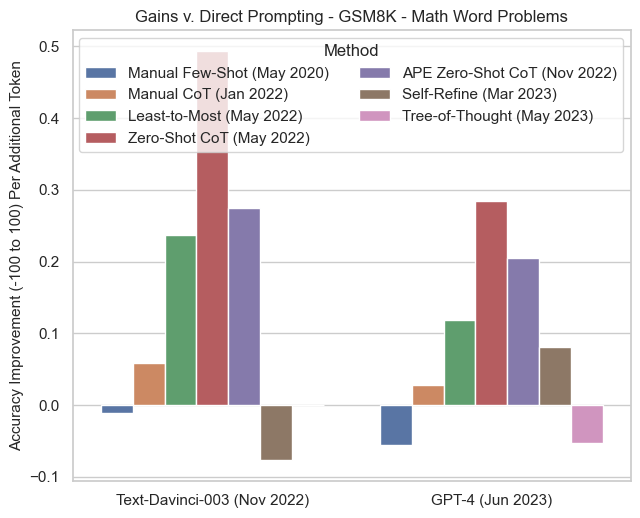

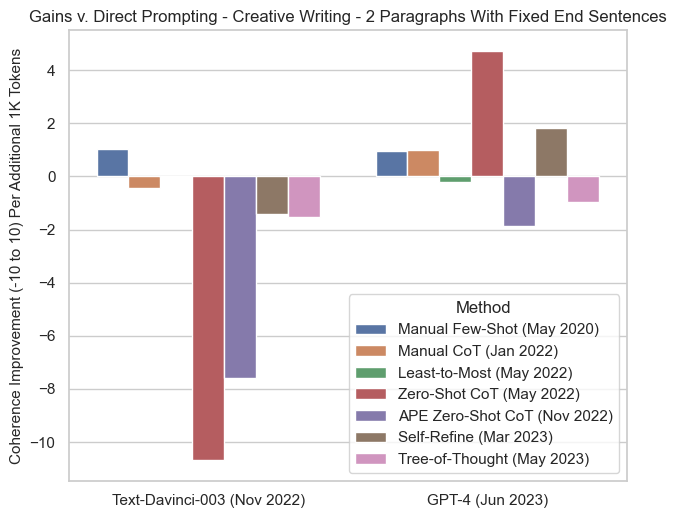

In [62]:
# Set figure size
figsize_16_9 = (16, 9)
# Scaled down a little
figsize_3_4 = (0.75 * 16, 0.75 * 9)
figsize_060 = (0.6 * 16, 0.6 * 9)
# Scaled down
figsize_half = (8, 4.5)
# Modified figsize to be a little taller
figsize_half_tall = (8*0.9, 6.5*0.9)
# Pick size
fsize = figsize_half_tall
fontsize_gsm8k = 11
fontsize_cw = 11
# Title padding
title_pad = 0

# Version sorted by ss_publication_date
# Merge on hand_labeled_data
# Add ss_publication_date to averages_for_changes
#print(averages_for_changes)
flattened_cols = [''.join(col).strip().replace('mean', '') for col in averages_for_changes.columns.values]
averages_for_changes.columns = flattened_cols
averages_for_changes_with_date = averages_for_changes.merge(hand_labeled_data, left_on='method', right_on='technique_name', how='left')
# Sort by ss_publication_date
averages_for_changes_with_date = averages_for_changes_with_date.sort_values('ss_publication_date')
print(averages_for_changes_with_date)

# Add Month and Year from the ss_publication_date column to the end of the Method column
averages_for_changes_with_date['Method'] = averages_for_changes_with_date['Method'] + ' (' + pd.to_datetime(averages_for_changes_with_date['ss_publication_date']).dt.strftime('%b %Y') + ')'

# Replace COT with CoT in Method
averages_for_changes_with_date['Method'] = averages_for_changes_with_date['Method'].str.replace('COT', 'CoT')
#print(averages_for_changes_with_date['Method'])

# Add Month and Year to the end of the Model column
# If Model = 'GPT-4', '(June 2023)'
# If Model = 'Text-Davinci-003', '(November 2022)'
averages_for_changes_with_date['Model'] = averages_for_changes_with_date['Model'] + ' ' + averages_for_changes_with_date['Model'].apply(lambda x: '(Jun 2023)' if x == 'GPT-4' else '(Nov 2022)')

# # Add stars for significant results
# # Merge on model, method, task with mcnemars_results and t_test_results
# averages_for_changes_with_date = averages_for_changes_with_date.merge(mcnemars_results[['model', 'method', 'task', 'pvalue']], on=['model', 'method', 'task'], how='left')
# # Rename pvalue to mcnemars_pvalue
# averages_for_changes_with_date = averages_for_changes_with_date.rename(columns={'pvalue': 'mcnemars_pvalue'})
# # Drop duplicates
# averages_for_changes_with_date = averages_for_changes_with_date.drop_duplicates()
# print('added pvals v1')
# print(averages_for_changes_with_date)
# # Merge
# # Limit t test results to coherence_1_incoherent_10_very_coherent
# print(t_test_results)
# t_test_results_coherence = t_test_results[t_test_results['metric'] == 'coherence_1_incoherent_10_very_coherent']
# averages_for_changes_with_date = averages_for_changes_with_date.merge(t_test_results_coherence[['model', 'method', 'task', 'pvalue']], on=['model', 'method', 'task'], how='left')
# # Rename pvalue to t_test_pvalue
# averages_for_changes_with_date = averages_for_changes_with_date.rename(columns={'pvalue': 't_test_pvalue'})
# # Drop duplicates
# averages_for_changes_with_date = averages_for_changes_with_date.drop_duplicates()
# print('added pvals v2')
# print(averages_for_changes_with_date)
# # Create column for stars that is '*' if mcnemars_pvalue < 0.05 and it is non-null, or '*' if t_test_pvalue < 0.05 and it is non-null
# averages_for_changes_with_date['stars'] = averages_for_changes_with_date.apply(lambda x: '*' if (x['mcnemars_pvalue'] < 0.05 and pd.notnull(x['mcnemars_pvalue'])) or (x['t_test_pvalue'] < 0.05 and pd.notnull(x['t_test_pvalue'])) else '', axis=1)
# # Add * to end of Method column
# averages_for_changes_with_date['Method'] = averages_for_changes_with_date['Method'] + averages_for_changes_with_date['stars']
# print('added stars')
# print(averages_for_changes_with_date)

# Create averages_for_changes_with_date_gsm8k and averages_for_changes_with_date_cw
averages_for_changes_with_date_gsm8k = averages_for_changes_with_date[averages_for_changes_with_date['task'] == 'gsm8k']
averages_for_changes_with_date_gsm8k['Percentage Points Accuracy Improvement Per Additional Token'] = averages_for_changes_with_date_gsm8k['change_in_accuracy_quality_per_change_in_conversation_length'] * 100
averages_for_changes_with_date_gsm8k['Percentage Points Accuracy Improvement Per 1,000 Additional Tokens'] = averages_for_changes_with_date_gsm8k['Percentage Points Accuracy Improvement Per Additional Token'] * 100 * 1000
averages_for_changes_with_date_cw = averages_for_changes_with_date[averages_for_changes_with_date['task'] == 'cw']
averages_for_changes_with_date_cw['Coherence Improvement (-10 to 10) Per Additional 1,000 Tokens'] = averages_for_changes_with_date_cw['change_in_accuracy_quality_per_change_in_conversation_length'] * 1000
# Sort dataframes by Model
averages_for_changes_with_date_gsm8k = averages_for_changes_with_date_gsm8k.sort_values(by=['Model'])
averages_for_changes_with_date_cw = averages_for_changes_with_date_cw.sort_values(by=['Model'])
print('split by task')
print(averages_for_changes_gsm8k)
print(averages_for_changes_cw)
#print(averages_for_changes_with_date)

#order_list = averages_for_changes_with_date[['Model', 'method']]
order_list = ['Text-Davinci-003 (Nov 2022)', 'GPT-4 (Jun 2023)']
#hue_order = list(averages_for_changes_with_date[['Method', 'ss_publication_date']].drop_duplicates().sort_values('ss_publication_date')['Method'])
# Separate hue_order for gsm8k and cw
hue_order_gsm8k = list(averages_for_changes_with_date_gsm8k[['Method', 'ss_publication_date']].drop_duplicates().sort_values('ss_publication_date')['Method'])
hue_order_cw = list(averages_for_changes_with_date_cw[['Method', 'ss_publication_date']].drop_duplicates().sort_values('ss_publication_date')['Method'])
#print(hue_order)
print(hue_order_gsm8k)
print(hue_order_cw)

# Plot change in accuracy_quality per change in conversation_length
# Bar chart by model, method, task
# GSM8k plot
plt.figure(figsize=fsize)
#sns.barplot(x='Model', y='Percentage Points Accuracy Improvement Per Additional Token', hue='Method', data=averages_for_changes_gsm8k)
ax = sns.barplot(x='Model', y='Percentage Points Accuracy Improvement Per Additional Token', hue='Method', hue_order=hue_order_gsm8k, data=averages_for_changes_with_date_gsm8k, order=order_list)
ax.legend(ncol=2, title = 'Method')
#, order=order_list)
#plt.xlabel('Model')
#plt.xlabel('')
#plt.ylabel('Change in GSM8K Accuracy per Change in Conversation Length')
# No x axis title
plt.gca().set_xlabel('')
# Reduce y axis title font size
plt.gca().set_ylabel('Accuracy Improvement (-100 to 100) Per Additional Token', fontsize=fontsize_gsm8k)
plt.title('Gains v. Direct Prompting - GSM8K - Math Word Problems')#, pad = title_pad)
plt.savefig('../Output/gsm8k_change_in_accuracy_quality_per_change_in_conversation_length_sorted_by_technique_age.png')
plt.show()

# # Plot change in accuracy_quality per change in conversation_length
# # Bar chart by model, method, task
# # GSM8k plot
# plt.figure(figsize=fsize)
# #sns.barplot(x='Model', y='Percentage Points Accuracy Improvement Per Additional Token', hue='Method', data=averages_for_changes_gsm8k)
# sns.barplot(x='Model', y='Percentage Points Accuracy Improvement Per 1,000 Additional Tokens', hue='Method', hue_order=hue_order, data=averages_for_changes_with_date_gsm8k)#, order=order_list)
# #plt.xlabel('Model')
# #plt.xlabel('')
# #plt.ylabel('Change in GSM8K Accuracy per Change in Conversation Length')
# # No x axis title
# plt.gca().set_xlabel('')
# # Reduce y axis title font size
# plt.gca().set_ylabel('Accuracy Improvement (-100 to 100) Per Additional 1K Additional Tokens')#, fontsize=10)
# #plt.title('Change in GSM8K Accuracy per Change in Conversation Length by Model and Method')
# plt.savefig('../Output/gsm8k_change_in_accuracy_quality_per_change_in_conversation_length_sorted_by_technique_age_transformed.png')
# plt.show()

# # Creative writing plot
# plt.figure(figsize=fsize)
# sns.barplot(x='Model', y='change_in_accuracy_quality_per_change_in_conversation_length', hue='Method', hue_order=hue_order_cw, data=averages_for_changes_with_date_cw, order=order_list)
# #sns.barplot(x='Model', y='change_in_accuracy_quality_per_change_in_conversation_length', hue='Method', data=averages_for_changes_cw)
# #plt.xlabel('')
# # plt.ylabel('Change in Creative Writing Coherence per Change in Conversation Length')
# #plt.title('Change in Creative Writing Coherence per Change in Conversation Length by Model and Method')
# # No x axis title
# plt.gca().set_xlabel('')
# plt.gca().set_ylabel('Coherence Improvement (-10 to 10) Per Additional Token', fontsize=10)
# plt.savefig('../Output/cw_change_in_accuracy_quality_per_change_in_conversation_length_sorted_by_technique_age.png')
# plt.show()

# Creative writing plot
plt.figure(figsize=fsize)
sns.barplot(x='Model', y='Coherence Improvement (-10 to 10) Per Additional 1,000 Tokens', hue='Method', hue_order=hue_order_cw, data=averages_for_changes_with_date_cw, order=order_list)
#sns.barplot(x='Model', y='change_in_accuracy_quality_per_change_in_conversation_length', hue='Method', data=averages_for_changes_cw)
#plt.xlabel('')
# plt.ylabel('Change in Creative Writing Coherence per Change in Conversation Length')
#plt.title('Change in Creative Writing Coherence per Change in Conversation Length by Model and Method')
# No x axis title
plt.gca().set_xlabel('')
plt.gca().set_ylabel('Coherence Improvement (-10 to 10) Per Additional 1K Tokens', fontsize=fontsize_cw)
plt.title('Gains v. Direct Prompting - Creative Writing - 2 Paragraphs With Fixed End Sentences')#, pad=title_pad)
plt.savefig('../Output/cw_change_in_accuracy_quality_per_change_in_conversation_length_sorted_by_technique_age_transformed.png')
plt.show()


In [63]:
# Also create a table with the change in accuracy_quality per change in conversation_length

# Unstack
# Pivot table - column method should go wide
change_per_table_pivot = averages_for_changes[['model', 'task', 'method', 'change_in_accuracy_quality_per_change_in_conversation_length']].set_index(['model', 'task', 'method']).unstack()
#pivot_table(index=['model', 'task'], columns='method', values='accuracy_quality').reset_index()

print(change_per_table_pivot)

# Fix axis
change_per_table_pivot = change_per_table_pivot.rename_axis([None, None], axis=1).reset_index()

# Sort rows by task - gsm8k task first, then cw
# Sort by model - text-davinci-003 first, then gpt4
change_per_table_pivot = change_per_table_pivot.sort_values(by=['task', 'model'], ascending=[True, True]).reset_index().drop(columns=['index'])

#print(avg_accuracy_quality_pivot.columns)

flattened_cols = [''.join(col).strip().replace('change_in_accuracy_quality_per_change_in_conversation_length', '') for col in change_per_table_pivot.columns.values]
change_per_table_pivot.columns = flattened_cols

#print(avg_accuracy_quality_pivot)

# Sort and output table

# Sort rows by task - gsm8k task first, then cw
# Sort by model - text-davinci-003 first, then gpt4
#change_per_table = change_per_table.sort_values(by=['task', 'model'], ascending=[True, True])

# Order columns: direct_prompting, zero_shot_cot, ape_zero_shot_cot, tree_of_thought, self_refine, least_to_most, manual_few_shot, manual_cot
change_per_table = change_per_table_pivot[['model', 'task', 'zero_shot_cot', 'ape_zero_shot_cot', 'tree_of_thought', 'self_refine', 'least_to_most', 'manual_few_shot', 'manual_cot']]

# Output to LaTeX
change_per_table.to_latex('../Output/change_per_table.tex', index=False)


            change_in_accuracy_quality_per_change_in_conversation_length  \
method                                                 ape_zero_shot_cot   
model task                                                                 
gpt4  cw                                             -0.001874             
      gsm8k                                           0.002057             
td3   cw                                             -0.007606             
      gsm8k                                           0.002746             

                                                                  \
method      least_to_most manual_cot manual_few_shot self_refine   
model task                                                         
gpt4  cw        -0.000225   0.000982        0.000967    0.001806   
      gsm8k      0.001185   0.000284       -0.000554    0.000807   
td3   cw        -0.000012  -0.000421        0.001030   -0.001430   
      gsm8k      0.002376   0.000582       -0.000112   -0.0

C:\Users\ijyli\AppData\Local\Temp\ipykernel_21568\1378987904.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  change_per_table_pivot = change_per_table_pivot.sort_values(by=['task', 'model'], ascending=[True, True]).reset_index().drop(columns=['index'])
